# **Install and Import Libraries**

In [1]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [47]:
import pandas as pd
import numpy as np

import torch

import torch.nn as nn
from torch.nn import functional as F
import os
import xml.etree.ElementTree as ET
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertForSequenceClassification, Trainer
from transformers import DataCollatorWithPadding, EarlyStoppingCallback, TrainingArguments
from transformers import AutoTokenizer, BertTokenizerFast, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from torch.utils.data import DataLoader
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import random

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Master/NLP/HW3/n2c2/n2c2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Helper functions**

In [4]:
# helper function

# Define normalization function
def normalize_text(text):
    text = re.sub(r'\d{4}-\d{2}-\d{2}', 'DATE', text)  # Replace dates with 'DATE'
    text = re.sub(r'\d{2}/\d{2}/\d{2}', 'DATE', text)  # Replace short dates with 'DATE'
    text = re.sub(r'\bDr\.\s\w+', 'DOCTOR', text)  # Replace doctor names with 'DOCTOR'
    text = re.sub(r'\bMr\.\s[A-Z][a-z]+\s[A-Z][a-z]+', 'PATIENT', text)  # Replace "Mr. Firstname Lastname"
    text = re.sub(r'\bMiss\s[A-Z][a-z]+\s[A-Z][a-z]+', 'PATIENT', text)  # Replace "Miss Firstname Lastname"
    text = re.sub(r'\bMrs\.\s[A-Z][a-z]+\s[A-Z][a-z]+', 'PATIENT', text)  # Replace "Mrs. Firstname Lastname"
    text = re.sub(r'\b[A-Z][a-z]+,\s[A-Z][a-z]+\sJr\.', 'PATIENT', text)  # Replace "Lastname, Firstname Jr."
    text = re.sub(r'\b[A-Z][a-z]+\s[A-Z][a-z]+\s[A-Z]\.', 'HOSPITAL', text)  # Replace hospital names with 'HOSPITAL'
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

# Define text cleaning function
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# **Part1: Document classfication**

## **Preprocessing**

In [6]:
part1_folder = data_path + 'part1/'

xml_trees = []
for filename in os.listdir(part1_folder):
  # Check if the file is an XML file
  if filename.endswith('.xml'):
      # Construct full file path
      file_path = os.path.join(part1_folder, filename)
      try:
          # Parse the XML file and get the root element
          tree = ET.parse(file_path)
          root = tree.getroot()
          xml_trees.append(root)
      except ET.ParseError as e:
          print(f'Error parsing {filename}: {e}')

In [7]:
columns = [
    'Text', 'ABDOMINAL', 'ADVANCED-CAD', 'ALCOHOL-ABUSE', 'ASP-FOR-MI', 'CREATININE',
    'DIETSUPP-2MOS', 'DRUG-ABUSE', 'ENGLISH', 'HBA1C', 'KETO-1YR', 'MAJOR-DIABETES',
    'MAKES-DECISIONS', 'MI-6MOS'
]
df = pd.DataFrame(columns=columns)

for i, xml in enumerate(xml_trees):
    text = xml[0].text
    tags = xml[1]
    sample_data = {'Text': text}
    for tag in tags:
        sample_data[tag.tag] = 1 if tag.attrib['met'] == 'met' else 0
    df.loc[i] = sample_data

# Apply normalization and cleaning to each text entry in the DataFrame
df['Cleaned_Text'] = df['Text'].apply(lambda x: clean_text(normalize_text(x)))

# Optionally, save the cleaned DataFrame to a CSV file
df.to_csv('cleaned_data.csv', index=False)

df.head()

,Text,ABDOMINAL,ADVANCED-CAD,ALCOHOL-ABUSE,ASP-FOR-MI,CREATININE,DIETSUPP-2MOS,DRUG-ABUSE,ENGLISH,HBA1C,KETO-1YR,MAJOR-DIABETES,MAKES-DECISIONS,MI-6MOS,Cleaned_Text
0,\n\nRecord date: 2126-01-29\n\nPersonal Data a...,0,1,0,0,0,0,0,1,0,0,0,1,0,record date date personal data overall health ...
1,\n\nRecord date: 2097-04-18\n\n\n\n\n\nMAH CAN...,1,1,0,1,1,1,0,1,0,0,0,1,0,record date date mah cancer center april ulise...
2,\n\nRecord date: 2059-06-19\n\nPROMPTCARE INTE...,1,0,0,1,1,1,0,1,1,0,1,1,0,record date date promptcare internal medicine ...
3,\n\nRecord date: 2120-10-23\n\nPatient Name: F...,0,1,0,1,0,1,0,1,1,0,1,1,0,record date date patient name flaherty xavier ...
4,\n\nRecord date: 2079-01-14\n\n\nPICH 9\n89 Ja...,0,0,0,1,0,0,0,1,1,0,0,1,0,record date date pich james street suite green...


In [10]:
diff = 0
for id_Test in range(len(df)):
  diff += len(df['Text'][id_Test]) - len(df['Cleaned_Text'][id_Test])
print(diff/len(df))

7828.4009900990095


## **TF-IDF Naive Bayes - Logistic Regression**

In [13]:
# TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Cleaned_Text'])

#target variables
y = df[['ABDOMINAL', 'ADVANCED-CAD', 'ALCOHOL-ABUSE', 'ASP-FOR-MI', 'CREATININE', 'DIETSUPP-2MOS', 'DRUG-ABUSE', 'ENGLISH', 'HBA1C', 'KETO-1YR', 'MAJOR-DIABETES', 'MAKES-DECISIONS', 'MI-6MOS']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# Logistic Regression model - cross-validation
lr = LogisticRegression(max_iter=1000, solver='liblinear')  # 'liblinear' :  good for small datasets
model = MultiOutputClassifier(lr)

In [26]:
def custom_multilabel_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    individual_accuracies = np.mean(y_true == y_pred, axis=0)
    return np.mean(individual_accuracies)

In [25]:
# Custom KFold for multi-label with balancing check
class BalancedKFold:
    def __init__(self, n_splits=5, shuffle=True, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X, y):
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)
        for train_index, test_index in kf.split(X):
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            if all(len(y_train[col].unique()) > 1 for col in y.columns):
                yield train_index, test_index

# cross-validation scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_micro': make_scorer(precision_score, average='micro', zero_division=1),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=1),
    'recall_micro': make_scorer(recall_score, average='micro', zero_division=1),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=1),
    'f1_micro': make_scorer(f1_score, average='micro', zero_division=1),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=1),
    'custom_accuracy': make_scorer(custom_multilabel_accuracy)
}

# custom cross-validation (due to unbalanced data)
cv = BalancedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {key: [] for key in scoring}
for train_idx, test_idx in cv.split(X_train, y_train):
    model.fit(X_train[train_idx], y_train.iloc[train_idx])
    y_pred = model.predict(X_train[test_idx])
    for key in scoring:
        score = scoring[key]._score_func(y_train.iloc[test_idx], y_pred, **scoring[key]._kwargs)
        cv_results[key].append(score)

#  mean and standard deviation for metrics
metrics = {key: (np.mean(cv_results[key]), np.std(cv_results[key])) for key in cv_results}

for metric, (mean, std) in metrics.items():
    print(f"{metric}: Mean = {mean:.4f}, Std = {std:.4f}")

model.fit(X_train, y_train)

accuracy: Mean = 0.0347, Std = 0.0120
precision_micro: Mean = 0.7776, Std = 0.0099
precision_macro: Mean = 0.8890, Std = 0.0042
recall_micro: Mean = 0.7520, Std = 0.0149
recall_macro: Mean = 0.5193, Std = 0.0175
f1_micro: Mean = 0.7644, Std = 0.0061
f1_macro: Mean = 0.4788, Std = 0.0135
custom_accuracy: Mean = 0.7975, Std = 0.0038


MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000,
                                                   solver='liblinear'))


Test Set Evaluation Metrics:
Accuracy: 0.0476
Precision (Micro): 0.7627
Precision (Macro): 0.8853
Recall (Micro): 0.7087
Recall (Macro): 0.5238
F1 Score (Micro): 0.7347
F1 Score (Macro): 0.4777
Custom Accuracy: 0.7619


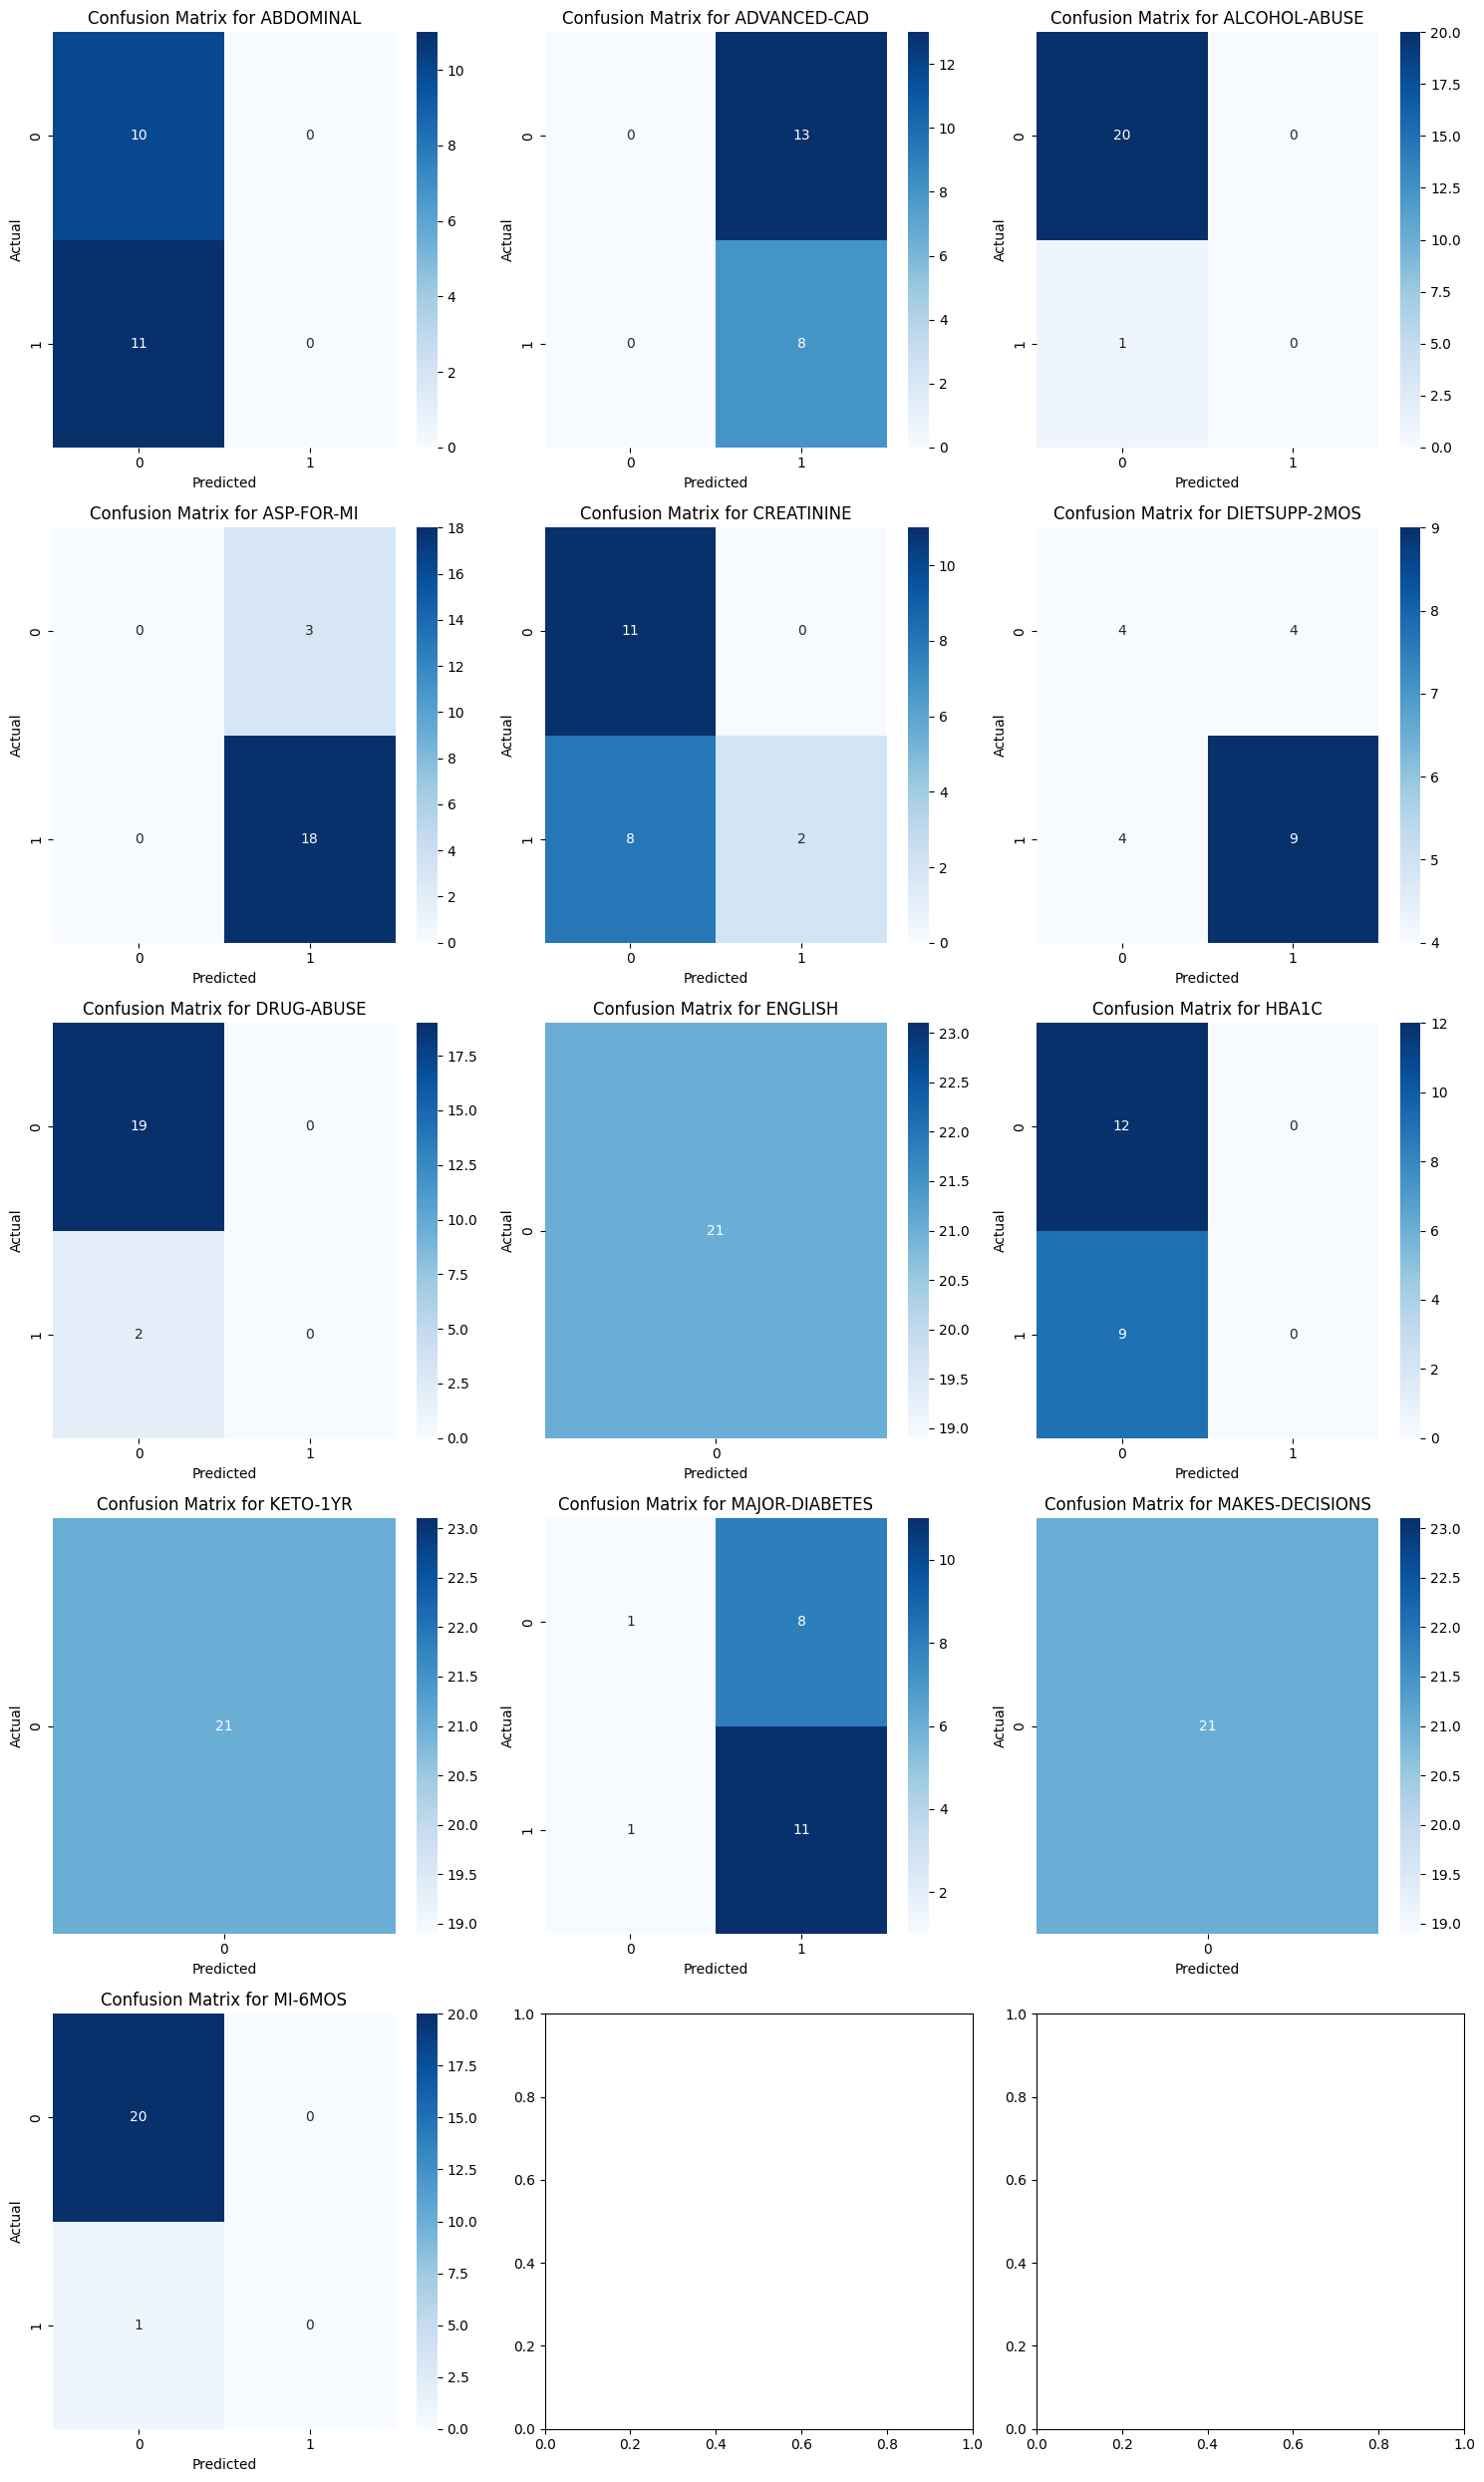

In [27]:
# predictions test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics -> test set
accuracy = accuracy_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=1)
precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=1)
recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=1)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=1)
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=1)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=1)
custom_accuracy = custom_multilabel_accuracy(y_test, y_pred)

print("\nTest Set Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Micro): {recall_micro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1 Score (Micro): {f1_micro:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"Custom Accuracy: {custom_accuracy:.4f}")

# Plot confusion matrices
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 25))
axes = axes.flatten()

for idx, label in enumerate(y.columns):
    conf_matrix = confusion_matrix(y_test[label], y_pred[:, idx])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix for {label}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()


## **Transformer based model - Bert**

In [32]:
df = pd.read_csv('cleaned_data.csv')

labels = [
    'ABDOMINAL',
    'ADVANCED-CAD',
    'ALCOHOL-ABUSE',
    'ASP-FOR-MI',
    'CREATININE',
    'DIETSUPP-2MOS',
    'DRUG-ABUSE',
    'ENGLISH',
    'HBA1C',
    'KETO-1YR',
    'MAJOR-DIABETES',
    'MAKES-DECISIONS',
    'MI-6MOS'
]

df['labels'] = df[labels].astype(float).values.tolist()

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Cleaned_Text'].tolist(),
    df['labels'].tolist(),
    test_size=0.2,
    random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42
)

In [33]:
print(len(train_texts))
print(len(val_texts))
print(len(test_texts))

161
20
21


In [34]:
train_labels[0]

[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]

In [35]:
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-v1.1')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

In [36]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [37]:
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

In [38]:
print(len(train_dataset))

161


In [39]:
train_dataset[0]

{'input_ids': tensor([  101,  1647,  2236,  2236,  3607,  1920, 26600,  3235,  5890,  3805,
          2255, 10296, 17811, 24928, 11955, 13791,  1596, 16312,  1116,  6857,
          1182, 26063,  1299,   172,  2087,   177,  1204,  1179,   176, 25081,
         19245,   188,  5208, 11776,   173,  1306,   172,  2087,  1893,  8167,
          4184, 23610,  5354,  6451,  1186,  1441,  1158, 10721,  1286,   190,
          1162, 14247,  2556, 27300,  1116,  2756,  1131,  3101, 12350,  1920,
          2057, 11344,  1268,  1289, 14247,  2556, 27300,  1116,  1723,  1286,
         11641, 11477,  1286, 11641,  5173, 16312,  1116,  1145, 16320,  1159,
          2756,  1131,  3101, 12350,  2057,  5048,  3992,  1562,  1286, 11641,
         11477, 10456,  1780,  5173,  1768, 16312,  1116,  1268,  1289, 14247,
          2556, 27300,  1218, 16320,  1915, 26360,  2455, 11111,  1757,  1664,
          7235, 25352,  1204,  1246,   172,  1204,  4366, 12104,  1965,  1679,
          2070,  6360,  2373,   181,  1

In [41]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [43]:
label_names = [
    'ABDOMINAL',
    'ADVANCED-CAD',
    'ALCOHOL-ABUSE',
    'ASP-FOR-MI',
    'CREATININE',
    'DIETSUPP-2MOS',
    'DRUG-ABUSE',
    'ENGLISH',
    'HBA1C',
    'KETO-1YR',
    'MAJOR-DIABETES',
    'MAKES-DECISIONS',
    'MI-6MOS'
]

model = BertForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.1', problem_type="multi_label_classification",num_labels=len(labels))

def compute_metrics(pred):
    labels = pred.label_ids
    preds = torch.sigmoid(torch.tensor(pred.predictions)) > 0.5  # Apply sigmoid and threshold
    precision = precision_score(labels, preds, average='samples')
    recall = recall_score(labels, preds, average='samples')
    f1 = f1_score(labels, preds, average='samples')
    acc = accuracy_score(labels, preds)
    custom_acc = custom_multilabel_accuracy(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'custom_acc': custom_acc
    }

training_arguments = TrainingArguments(
    output_dir="./out",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    logging_steps=10,
    weight_decay=0.01,
    save_total_limit=2,  # Limit the total amount of checkpoints, delete the older ones
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="eval_loss",  # The metric to use to compare models
    greater_is_better=False
)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics = compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Custom Acc
1,0.572000,0.482542,0.000000,0.741187,0.733333,0.793929,0.773077
2,0.475500,0.449632,0.000000,0.741187,0.733333,0.793929,0.773077
3,0.456800,0.441144,0.050000,0.698932,0.760000,0.677480,0.757692
4,0.426600,0.442441,0.000000,0.721191,0.743333,0.745040,0.761538
5,0.447700,0.432230,0.000000,0.741187,0.733333,0.793929,0.773077
6,0.416000,0.447800,0.000000,0.709591,0.747500,0.718254,0.753846
7,0.433000,0.435803,0.050000,0.698932,0.760000,0.677480,0.757692
8,0.433900,0.436366,0.000000,0.750076,0.746667,0.793929,0.780769
9,0.421600,0.436107,0.000000,0.733558,0.748333,0.764762,0.769231
10,0.393900,0.429459,0.000000,0.739028,0.741905,0.773095,0.776923


TrainOutput(global_step=242, training_loss=0.3683965068218137, metrics={'train_runtime': 733.0752, 'train_samples_per_second': 10.981, 'train_steps_per_second': 0.75, 'total_flos': 932031400667136.0, 'train_loss': 0.3683965068218137, 'epoch': 22.0})

In [44]:
model.save_pretrained('./bio-bert-multilabel')
tokenizer.save_pretrained('./bio-bert-multilabel')

('./bio-bert-multilabel/tokenizer_config.json',
 './bio-bert-multilabel/special_tokens_map.json',
 './bio-bert-multilabel/vocab.txt',
 './bio-bert-multilabel/added_tokens.json')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Class: ABDOMINAL
  Precision: 0.2222
  Recall: 0.2857
  F1 Score: 0.2500
  Confusion Matrix:
[[7 7]
 [5 2]]

  Class: ADVANCED-CAD
  Precision: 0.5238
  Recall: 1.0000
  F1 Score: 0.6875
  Confusion Matrix:
[[ 0 10]
 [ 0 11]]

  Class: ALCOHOL-ABUSE
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  Confusion Matrix:
[[19  0]
 [ 2  0]]

  Class: ASP-FOR-MI
  Precision: 0.8571
  Recall: 1.0000
  F1 Score: 0.9231
  Confusion Matrix:
[[ 0  3]
 [ 0 18]]

  Class: CREATININE
  Precision: 0.3333
  Recall: 0.4286
  F1 Score: 0.3750
  Confusion Matrix:
[[8 6]
 [4 3]]

  Class: DIETSUPP-2MOS
  Precision: 0.4444
  Recall: 0.8889
  F1 Score: 0.5926
  Confusion Matrix:
[[ 2 10]
 [ 1  8]]

  Class: DRUG-ABUSE
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  Confusion Matrix:
[[18  0]
 [ 3  0]]

  Class: ENGLISH
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
  Confusion Matrix:
[[21]]

  Class: HBA1C
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  Confusion Matri

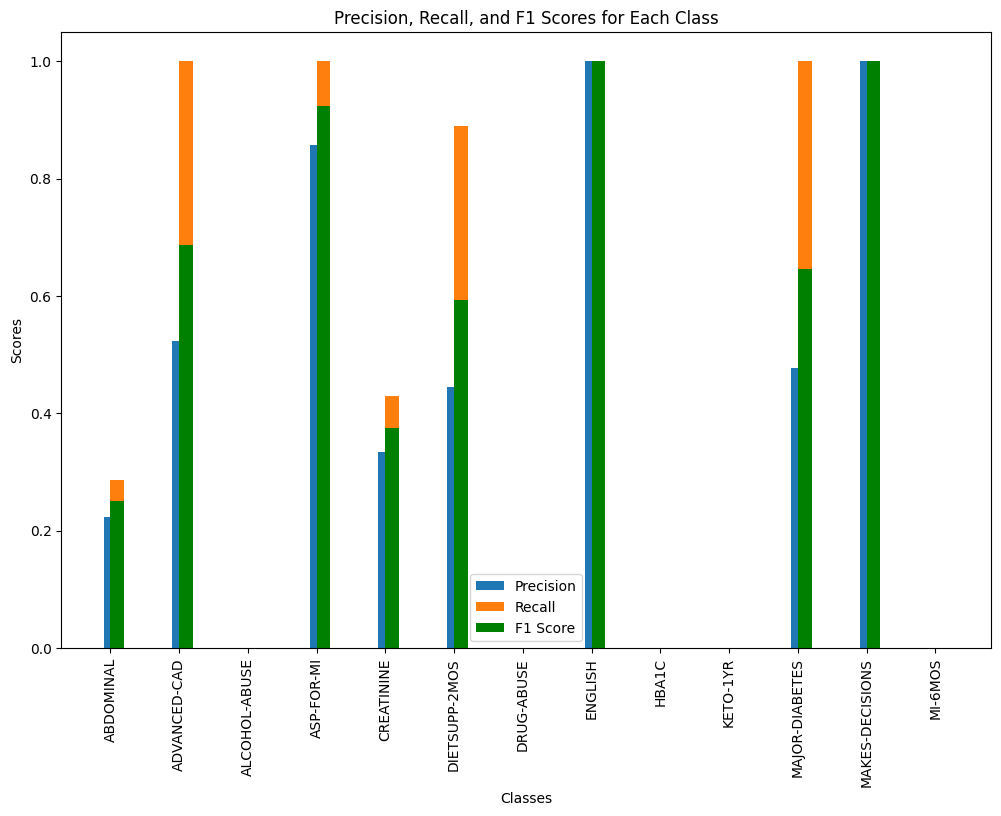

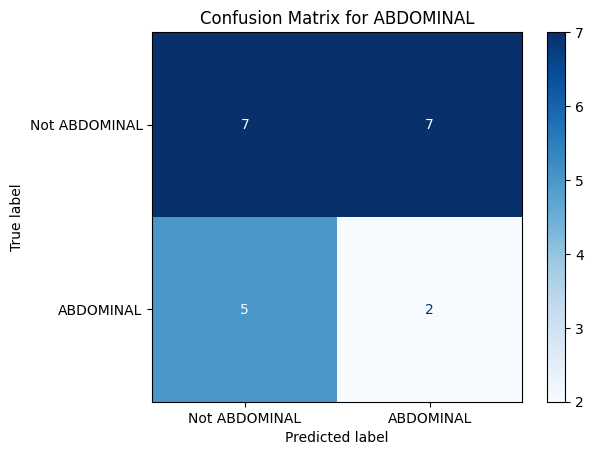

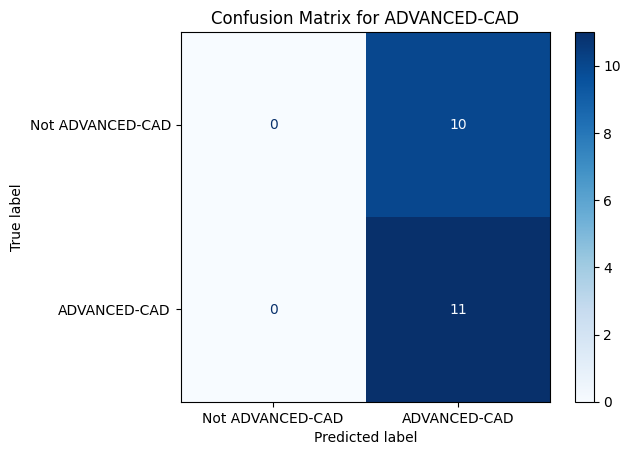

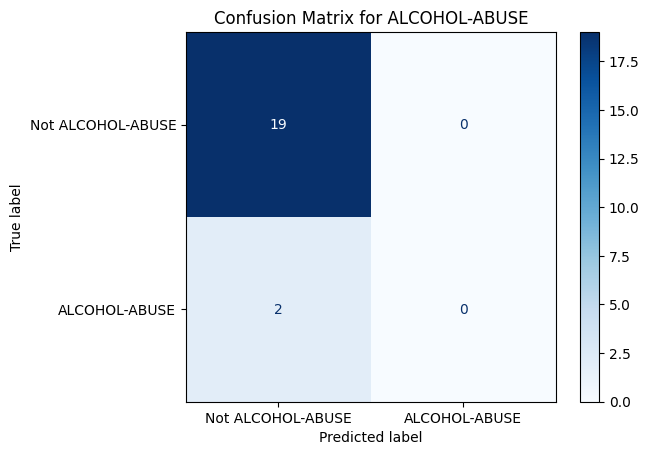

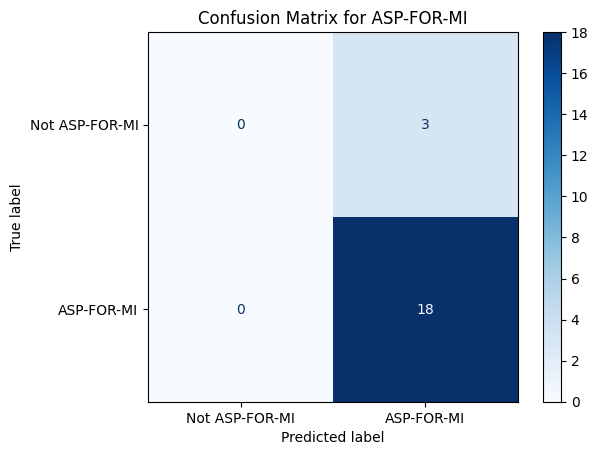

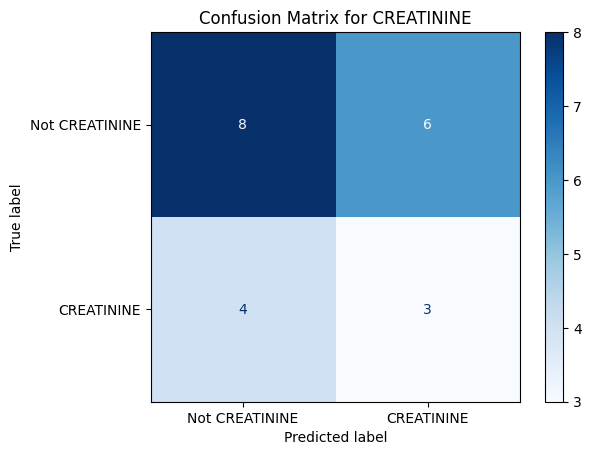

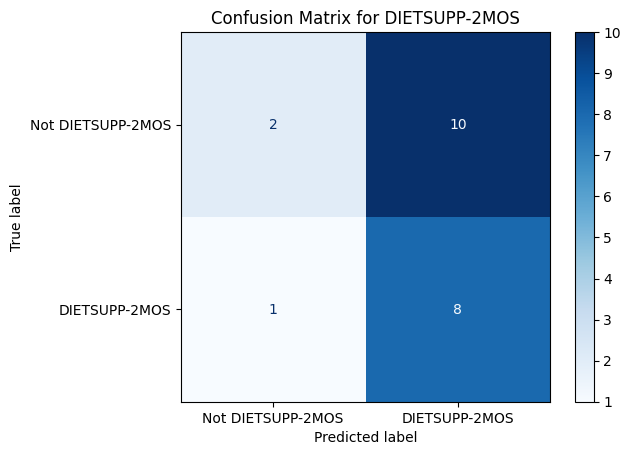

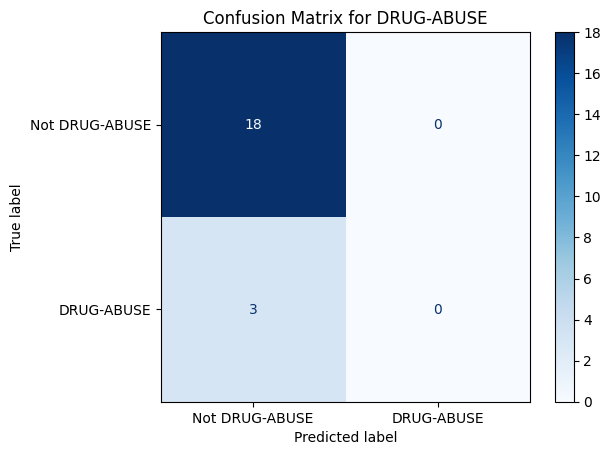

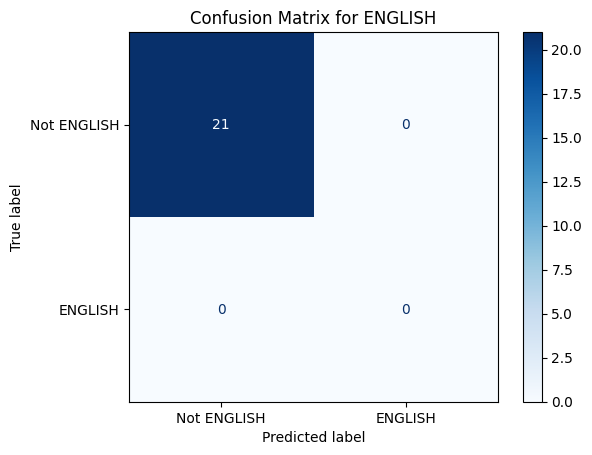

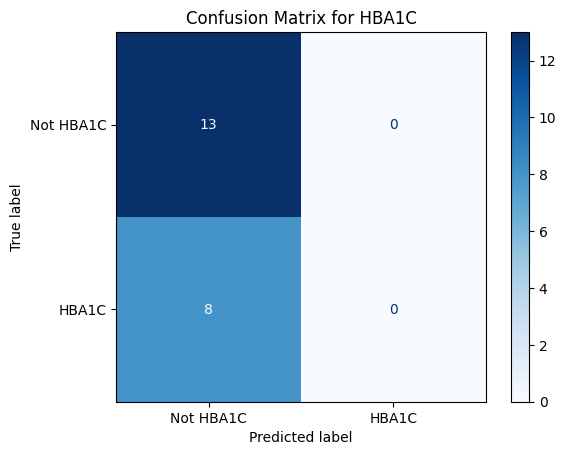

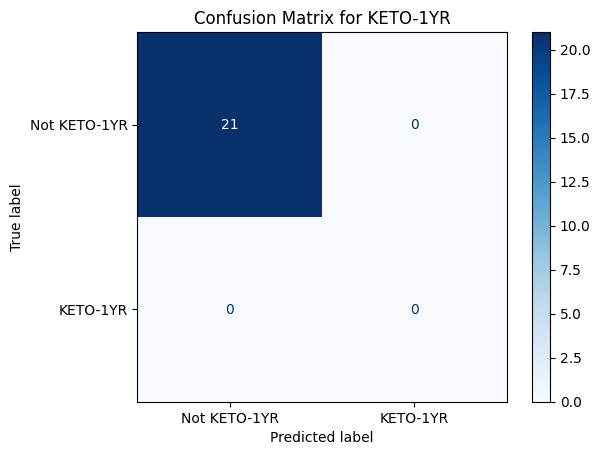

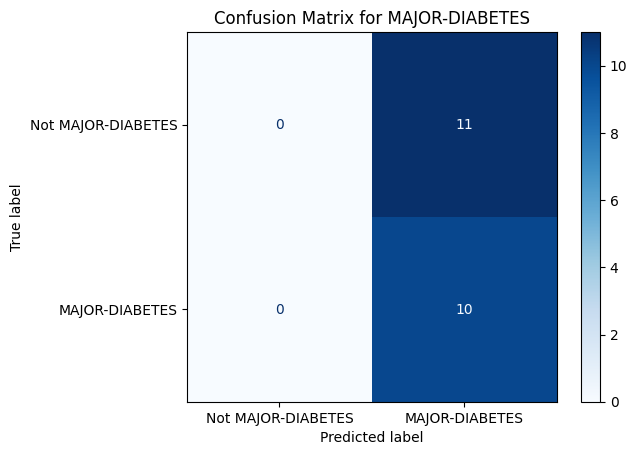

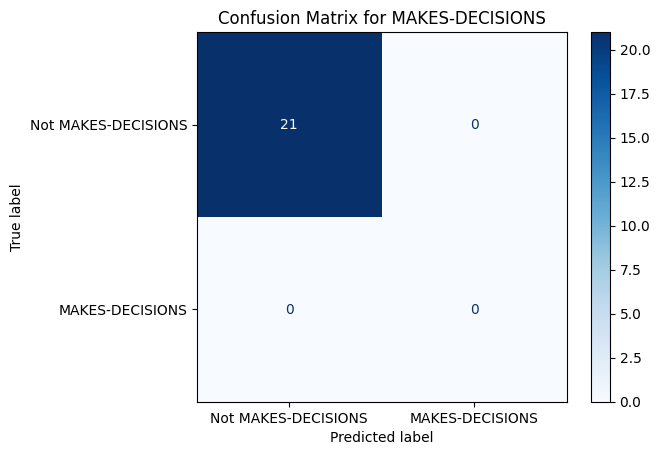

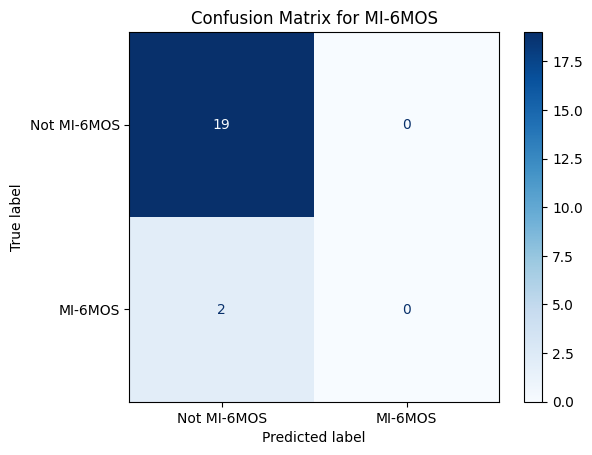

In [45]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy


def evaluate_model_on_test():
    test_predictions = trainer.predict(test_dataset)
    labels = test_predictions.label_ids
    preds = torch.sigmoid(torch.tensor(test_predictions.predictions)) > 0.5  # Apply sigmoid and threshold

    # Compute detailed classification report
    detailed_report = classification_report(labels, preds, target_names=label_names, output_dict=True)

    # Extract per-class metrics and confusion matrices
    per_class_metrics = {}
    confusion_matrices = {}
    for i, label in enumerate(label_names):
        per_class_metrics[label] = {
            'precision': detailed_report[label]['precision'],
            'recall': detailed_report[label]['recall'],
            'f1': detailed_report[label]['f1-score']
        }
        confusion_matrices[label] = confusion_matrix(labels[:, i], preds[:, i])

    return per_class_metrics, confusion_matrices

# Get per-class metrics and confusion matrices
per_class_metrics, confusion_matrices = evaluate_model_on_test()

# Print per-class metrics and confusion matrices
for label, metrics in per_class_metrics.items():
    print(f"  Class: {label}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1 Score: {metrics['f1']:.4f}")
    print(f"  Confusion Matrix:\n{confusion_matrices[label]}")
    print()

# Plot the results
def plot_metrics(per_class_metrics, labels):
    classes = list(per_class_metrics.keys())
    precisions = [per_class_metrics[label]['precision'] for label in classes]
    recalls = [per_class_metrics[label]['recall'] for label in classes]
    f1_scores = [per_class_metrics[label]['f1'] for label in classes]

    x = range(len(classes))

    plt.figure(figsize=(12, 8))
    plt.bar(x, precisions, width=0.2, label='Precision', align='center')
    plt.bar(x, recalls, width=0.2, label='Recall', align='edge')
    plt.bar(x, f1_scores, width=0.2, label='F1 Score', align='edge', color='g')

    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title('Precision, Recall, and F1 Scores for Each Class')
    plt.xticks(x, labels, rotation=90)
    plt.legend()
    plt.show()

# Plot the per-class metrics
plot_metrics(per_class_metrics, label_names)

# Plot confusion matrices for each class
def plot_confusion_matrices(confusion_matrices):
    for label, cm in confusion_matrices.items():
        if len(cm) == 1:
            cm = [[cm[0][0], 0], [0, 0]]
            cm = numpy.array(cm)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Not {label}', label])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {label}')
        plt.show()

# Plot the confusion matrices
plot_confusion_matrices(confusion_matrices)


In [ ]:
test_results = trainer.evaluate(test_dataset)
print(test_results)

{'eval_loss': 0.3386370539665222, 'eval_accuracy': 0.3225806451612903, 'eval_f1': 0.8625748855824757, 'eval_precision': 0.858026113671275, 'eval_recall': 0.9012928827444957, 'eval_runtime': 0.8909, 'eval_samples_per_second': 34.795, 'eval_steps_per_second': 2.245, 'epoch': 29.0}


# **Part2: Token classification**

## **Preprocessing**

In [ ]:
part2_folder = data_path + 'part2/'

# Initialize an empty DataFrame with the required columns
df = pd.DataFrame(columns=['id', 'Text', 'Annotation'])

# Create a dictionary to temporarily store file contents
file_contents = {}

for filename in os.listdir(part2_folder):
    file_path = os.path.join(part2_folder, filename)

    if filename.endswith('.txt'):
        with open(file_path, 'r') as file_:
            text = file_.read()
            file_id = filename.rsplit('.', 1)[0]
            if file_id not in file_contents:
                file_contents[file_id] = {}
            file_contents[file_id]['Text'] = text

    elif filename.endswith('.ann'):
        with open(file_path, 'r') as file_:

            annotation = file_.read()
            entities = annotation.split('\n')
            # for entity in entities:
            #     if entity:
            #         cols = entity.split('\t')
            #         if 'T' in cols[0]:
            #             type_ = cols[1].split()[0]
            #             token = cols[2]
            #             # label = cols[3]
            #             print(cols[0], type_, '---' ,token)

            # break

            file_id = filename.rsplit('.', 1)[0]
            if file_id not in file_contents:
                file_contents[file_id] = {}
            file_contents[file_id]['Annotation'] = annotation

# print(file_contents)
# Populate the DataFrame with the collected data
i=0
for file_id, contents in file_contents.items():
    text = contents.get('Text', '')
    annotation = contents.get('Annotation', '')
    # df = df.append({'id': file_id, 'Text': text, 'Annotation': annotation}, ignore_index=True)
    df.loc[i] = {'id': file_id, 'Text': text, 'Annotation': annotation}
    i+=1

In [ ]:
df.head()

,id,Text,Annotation
0,100035,Admission Date: [**2115-2-22**] ...,T1\tReason 10179 10197\trecurrent seizures\nR1...
1,100229,Admission Date: [**2114-12-24**] ...,T1\tDuration 1003 1011\tfive-day\nR1\tDuration...
2,100039,Admission Date: [**2174-4-18**] ...,T1\tDrug 13213 13222\tmilrinone\nT2\tDrug 1340...
3,100564,Admission Date: [**2144-1-20**] ...,T1\tDrug 1340 1343\ttPA\nT2\tRoute 1344 1352\t...
4,100579,Admission Date: [**2125-10-17**] ...,T1\tStrength 10008 10012\t50mg\nR1\tStrength-D...


In [ ]:
# Apply normalization and cleaning to each text entry in the DataFrame
df['Cleaned_Text'] = df['Text'].apply(lambda x: clean_text(normalize_text(x)))
df.head()

,id,Text,Annotation,Cleaned_Text
0,100035,Admission Date: [**2115-2-22**] ...,T1\tReason 10179 10197\trecurrent seizures\nR1...,admission date discharge date date birth sex s...
1,100229,Admission Date: [**2114-12-24**] ...,T1\tDuration 1003 1011\tfive-day\nR1\tDuration...,admission date date discharge date date birth ...
2,100039,Admission Date: [**2174-4-18**] ...,T1\tDrug 13213 13222\tmilrinone\nT2\tDrug 1340...,admission date discharge date date birth date ...
3,100564,Admission Date: [**2144-1-20**] ...,T1\tDrug 1340 1343\ttPA\nT2\tRoute 1344 1352\t...,admission date discharge date date birth sex s...
4,100579,Admission Date: [**2125-10-17**] ...,T1\tStrength 10008 10012\t50mg\nR1\tStrength-D...,admission date date discharge date date date b...


In [ ]:
id2label = {
    "0": "O",
    "1": "B-Drug",
    "2": "B-Strength",
    "3": "B-Form",
    "4": "B-Dosage",
    "5": "B-Duration",
    "6": "B-Frequency",
    "7": "B-Route",
    "8": "B-ADE",
    "9": "B-Reason",
    "10": "I-Drug",
    "11": "I-Strength",
    "12": "I-Form",
    "13": "I-Dosage",
    "14": "I-Duration",
    "15": "I-Frequency",
    "16": "I-Route",
    "17": "I-ADE",
    "18": "I-Reason"
}
label2id = {v: k for k, v in id2label.items()}

print("id2label =", id2label)
print("label2id =", label2id)


id2label = {'0': 'O', '1': 'B-Drug', '2': 'B-Strength', '3': 'B-Form', '4': 'B-Dosage', '5': 'B-Duration', '6': 'B-Frequency', '7': 'B-Route', '8': 'B-ADE', '9': 'B-Reason', '10': 'I-Drug', '11': 'I-Strength', '12': 'I-Form', '13': 'I-Dosage', '14': 'I-Duration', '15': 'I-Frequency', '16': 'I-Route', '17': 'I-ADE', '18': 'I-Reason'}
label2id = {'O': '0', 'B-Drug': '1', 'B-Strength': '2', 'B-Form': '3', 'B-Dosage': '4', 'B-Duration': '5', 'B-Frequency': '6', 'B-Route': '7', 'B-ADE': '8', 'B-Reason': '9', 'I-Drug': '10', 'I-Strength': '11', 'I-Form': '12', 'I-Dosage': '13', 'I-Duration': '14', 'I-Frequency': '15', 'I-Route': '16', 'I-ADE': '17', 'I-Reason': '18'}


In [ ]:
df.loc[1]['Text']

"Admission Date:  [**2114-12-24**]              Discharge Date:   [**2115-1-6**]\n\nDate of Birth:  [**2070-12-17**]             Sex:   M\n\nService: MEDICINE\n\nAllergies:\nHeparin Agents\n\nAttending:[**First Name3 (LF) 943**]\nChief Complaint:\nHypotension with elevated lactate, code sepsis.\n\nMajor Surgical or Invasive Procedure:\nRight internal jugular venous catheter placement.\n\n\nHistory of Present Illness:\n44 yoM PMH ESRD secondary to Brights disease on HD s/p two\nfailed renal transplants, HCV, CHF with EF 20%, AF on coumadin\nwho presented to the ED with a two week history of diffuse\nabdominal pain with one day of nausea and vomiting [**2114-12-24**]. Two\nweeks prior to admission the patient began to experience diffuse\ndull abdominal pain without nausea or vomiting and loose stools\n2-3 times per day. The patient believed this was secondary to\nfluid overload. One week prior to presentation the patient\ncomplained of subjective fevers, cough productive of yellow\nsputu

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
encoded_input = tokenizer(list(df['Text'].to_numpy()), padding=True, truncation=True, max_length=100, return_tensors="pt")

# print(encoded_input)
print('output shape: ', encoded_input['input_ids'].shape)

output shape:  torch.Size([303, 100])


In [ ]:
def find_sublist_index(sublist, main_list):
    # Lengths of the sublist and main_list
    len_sublist = len(sublist)
    len_main_list = len(main_list)

    # Iterate over possible starting indices in main_list
    for i in range(len_main_list - len_sublist + 1):
        # Check if the sublist matches the slice of main_list starting at index i
        if main_list[i:i+len_sublist] == sublist:
            return i  # Return the starting index of the match

    return -1  # Return -1 if sublist is not found

In [ ]:
outputs = []

for i, encode in enumerate(encoded_input['input_ids']):
  tokens = tokenizer.convert_ids_to_tokens(encode)
  # print(tokens)

  entities = df['Annotation'][i].split('\n')

  out = np.zeros((1, encoded_input['input_ids'].shape[1]), dtype=int)
  idx = 0
  for entity in entities:
      if entity:
          cols = entity.split('\t')
          if 'T' in cols[0]:
              type_ = cols[1].split()[0]
              token = cols[2]
              # label = cols[3]
              # print(cols[0], type_, '---' ,token)
              token_tokenized = tokenizer(token, padding=True, truncation=True, return_tensors="pt")
              sublist = tokenizer.convert_ids_to_tokens(token_tokenized['input_ids'][0])[1:-1]

              begin = find_sublist_index(sublist, tokens)
              if begin != -1 and begin > idx:
                # print('index: ', begin)
                # print(sublist)
                # print(tokens[begin: begin +5])
                idx = begin + len(sublist) - 1

                # print('class id: ', label2id[f'B-{type_}'])
                # print('class id: ', label2id[f'I-{type_}'])
                out[0, begin] = label2id[f'B-{type_}']
                for i in range(1, len(sublist)):
                  out[0, begin+i] = label2id[f'I-{type_}']

              # print(tokens.index(token))
  # print(out)
  outputs.append(out)

output_np = np.vstack(outputs)
output_np.shape

(303, 100)

In [ ]:
def encode_class(label):
  # Number of classes
  num_classes = len(id2label)

  # Convert class numbers to one-hot encoding
  one_hot_encoded = np.eye(num_classes)[label]

  return one_hot_encoded

output_encoded = encode_class(output_np)

In [ ]:
# input_embedding.last_hidden_state.shape, output_encoded.shape

In [ ]:
from sklearn.model_selection import train_test_split

texts = list(df['Text'].to_numpy())
texts_train, texts_val, output_train, output_val = train_test_split(texts, output_encoded, test_size=0.2, random_state=42)
texts_val, texts_test, output_val, output_test = train_test_split(texts_val, output_val, test_size=0.5, random_state=42)

output_train.shape, output_val.shape, output_test.shape

((242, 100, 19), (30, 100, 19), (31, 100, 19))

In [ ]:
import torch
from torch.utils.data import Dataset

class TokenClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, model):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):

        tokenized = tokenizer(self.texts[idx], padding=True, truncation=True, max_length=100, return_tensors="pt")
        # input_ids = self.texts['input_ids'][idx]
        # attention_mask = self.texts['attention_mask'][idx]
        # token_type_ids = self.texts['token_type_ids'][idx]

        label = self.labels[idx]

        # print(tokenized)
        # get embedding
        input_embedding = model(**tokenized)
        # input_embedding = model(**{'input_ids': input_ids.unsqueeze(0), 'token_type_ids': token_type_ids.unsqueeze(0), 'attention_mask': attention_mask.unsqueeze(0)})

        return input_embedding.last_hidden_state.squeeze(0).float(), torch.tensor(label, dtype=torch.float32)


trainset = TokenClassificationDataset(texts_train, output_train, tokenizer, model)
valset = TokenClassificationDataset(texts_val, output_val, tokenizer, model)
testset = TokenClassificationDataset(texts_test, output_val, tokenizer, model)

# Check a sample from the dataset
sample = trainset[0]
print(sample[0].dtype, sample[1].dtype)

torch.float32 torch.float32


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
        dataset=trainset,
        batch_size=20,
)
val_loader = DataLoader(
        dataset=valset,
        batch_size=20,
)
test_loader = DataLoader(
        dataset=testset,
        batch_size=20,
)

## **LSTM model**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Linear(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Linear(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        input = trg[0, :]
        for t in range(1, trg_length):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else torch.tensor(encode_class(top1.cpu()), dtype=torch.float32).to(self.device)
        return outputs

In [ ]:
input_dim = 768
output_dim = 19
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('device: ', device)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model_seq = Seq2Seq(encoder, decoder, device).to(device)

device:  cuda


In [ ]:
# from torch.nn import optim
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    correct = 0
    for i, batch in enumerate(data_loader):
        src, trg  = batch

        src = src.reshape((src.shape[1], src.shape[0], -1))
        trg = trg.reshape((trg.shape[1], trg.shape[0], -1))

        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1, output_dim)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

        preds = torch.argmax(output, dim=1) #output.max(1)
        targets = torch.argmax(trg, dim=1) #trg.max(1)

        correct += preds.eq(targets).sum().item()

    return epoch_loss / len(data_loader), correct / (len(data_loader.dataset) * 100)


def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct = 0

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src, trg  = batch

            src = src.reshape((src.shape[1], src.shape[0], -1))
            trg = trg.reshape((trg.shape[1], trg.shape[0], -1))

            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0)  # turn off teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1, output_dim)
            loss = criterion(output, trg)
            epoch_loss += loss.item()

            preds = torch.argmax(output, dim=1) #output.max(1)
            targets = torch.argmax(trg, dim=1) #trg.max(1)

            correct += preds.eq(targets).sum().item()

    return epoch_loss / len(data_loader), correct / (len(data_loader.dataset) * 100)


def test_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct = 0

    predictions, ground_truth = [], []
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src, trg  = batch

            src = src.reshape((src.shape[1], src.shape[0], -1))
            trg = trg.reshape((trg.shape[1], trg.shape[0], -1))

            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0)  # turn off teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1, output_dim)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

            preds = torch.argmax(output, dim=1) #output.max(1)
            targets = torch.argmax(trg, dim=1) #trg.max(1)
            predictions.extend(preds.cpu().numpy())
            ground_truth.extend(targets.cpu().numpy())

            correct += preds.eq(targets).sum().item()

    precision = precision_score(ground_truth, predictions, average='weighted')
    recall = recall_score(ground_truth, predictions, average='weighted')
    f1 = f1_score(ground_truth, predictions, average='weighted')

    return epoch_loss / len(data_loader), correct / (len(data_loader.dataset) * 100), precision, recall, f1

In [ ]:
n_epochs = 20
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")
best_valid_acc = 0


data_path = "/content/drive/MyDrive/nlp/HW3/"
for epoch in range(n_epochs):
    train_loss, acc = train_fn(
        model_seq,
        train_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss, val_acc = evaluate_fn(
        model_seq,
        val_loader,
        criterion,
        device,
    )
    if val_acc > best_valid_acc:
        best_valid_loss = valid_loss
        best_valid_acc = val_acc
        torch.save(model.state_dict(), data_path+"seq_model.pt")

    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f} | Train Acc: {acc:.4f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f} | Valid Acc: {val_acc:.4f}")



	Train Loss:   2.956 | Train PPL:  19.226 | Train Acc: 0.0131
	Valid Loss:   2.953 | Valid PPL:  19.169 | Valid Acc: 0.0387
	Train Loss:   2.951 | Train PPL:  19.132 | Train Acc: 0.0338
	Valid Loss:   2.951 | Valid PPL:  19.132 | Valid Acc: 0.0487
	Train Loss:   2.950 | Train PPL:  19.112 | Train Acc: 0.0381
	Valid Loss:   2.950 | Valid PPL:  19.101 | Valid Acc: 0.0487
	Train Loss:   2.949 | Train PPL:  19.092 | Train Acc: 0.0426
	Valid Loss:   2.948 | Valid PPL:  19.071 | Valid Acc: 0.0487
	Train Loss:   2.948 | Train PPL:  19.075 | Train Acc: 0.0457
	Valid Loss:   2.947 | Valid PPL:  19.041 | Valid Acc: 0.0587
	Train Loss:   2.947 | Train PPL:  19.055 | Train Acc: 0.0478
	Valid Loss:   2.945 | Valid PPL:  19.013 | Valid Acc: 0.0587
	Train Loss:   2.947 | Train PPL:  19.045 | Train Acc: 0.0510
	Valid Loss:   2.944 | Valid PPL:  18.988 | Valid Acc: 0.0587


In [ ]:
# calculating F1 score, precision, and recall for testset

input_dim = 768
output_dim = 19
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)
model_seq = Seq2Seq(encoder, decoder, device).to(device)
data_path = "/content/drive/MyDrive/nlp/HW3/"
model_seq.load_state_dict(torch.load(data_path+"seq_model.pt"))

test_loss, test_acc, precision, recall, f1 = test_fn(
        model_seq,
        val_loader,
        criterion,
        device,
)
print(f'Test Loss: {test_loss}, Test Acc: {test_acc}, Precision: {precision}, Recall: {recall}, F1: {f1}')

Test Loss: 2.921250343322754, Test Acc: 0.0003333333333333333, Precision: 4.489337822671156e-07, Recall: 0.0003367003367003367, F1: 8.966720018650777e-07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Transformer based model**

In [ ]:
part2_folder = data_path + 'part2'

In [ ]:
df = pd.DataFrame(columns=['id', 'Text', 'Annotation'])

file_contents = {}

for filename in os.listdir(part2_folder):
    file_path = os.path.join(part2_folder, filename)

    if filename.endswith('.txt'):
        with open(file_path, 'r') as file_:
            text = file_.read()
            file_id = filename.rsplit('.', 1)[0]
            if file_id not in file_contents:
                file_contents[file_id] = {}
            file_contents[file_id]['Text'] = text

    elif filename.endswith('.ann'):
        with open(file_path, 'r') as file_:

            annotation = file_.read()
            entities = annotation.split('\n')

            file_id = filename.rsplit('.', 1)[0]
            if file_id not in file_contents:
                file_contents[file_id] = {}
            file_contents[file_id]['Annotation'] = annotation

i=0
for file_id, contents in file_contents.items():
    text = contents.get('Text', '')
    annotation = contents.get('Annotation', '')
    df.loc[i] = {'id': file_id, 'Text': text, 'Annotation': annotation}
    i+=1

In [ ]:
df.head()

,id,Text,Annotation
0,159079,Admission Date: [**2110-8-7**] D...,T1\tStrength 10013 10017\t20mg\nR1\tStrength-D...
1,175593,Admission Date: [**2122-6-19**] ...,T1\tDrug 171 179\tfentanyl\nT2\tDrug 182 191\t...
2,106384,Admission Date: [**2151-1-25**] ...,T1\tDrug 10111 10119\tcoumadin\nT2\tDrug 10191...
3,101215,Admission Date: [**2142-8-14**] ...,T1\tDrug 171 182\tPenicillins\nT2\tReason 4253...
4,124917,Admission Date: [**2190-5-21**] ...,T1\tDrug 5702 5710\tPrecedex\nT2\tDrug 7626 76...


In [ ]:
label_mapping = {
    "O": 0,
    "B-Drug": 1,
    "B-Strength": 2,
    "B-Form": 3,
    "B-Dosage": 4,
    "B-Duration": 5,
    "B-Frequency": 6,
    "B-Route": 7,
    "B-ADE": 8,
    "B-Reason": 9,
    "I-Drug": 10,
    "I-Strength": 11,
    "I-Form": 12,
    "I-Dosage": 13,
    "I-Duration": 14,
    "I-Frequency": 15,
    "I-Route": 16,
    "I-ADE": 17,
    "I-Reason": 18
}

def parse_annotations(row):
    text = row['Text']
    annotations = row['Annotation'].split('\n')

    entities = []
    for ann in annotations:
        parts = ann.split('\t')
        if len(parts) < 3 or parts[0].startswith('R') or parts[0].startswith('A'):
            continue
        entity_type = parts[1].split()[0]
        indices = parts[1].split()[1:]
        try:
            start_idx = int(indices[0].split(';')[0])
            end_idx = int(indices[-1].split(';')[-1])
        except ValueError:
            continue
        entity_text = parts[2]
        entities.append((entity_type, start_idx, end_idx, entity_text))

    return text, entities

parsed_data = df.apply(parse_annotations, axis=1)
texts = parsed_data.apply(lambda x: x[0])
entities = parsed_data.apply(lambda x: x[1])

tokenizer = BertTokenizerFast.from_pretrained('georgeleung30/bert-finetuned-n2c2-ner')

def tokenize_and_align_labels(texts, entities, label_mapping):
    tokenized_inputs = tokenizer(texts.to_list(), truncation=True, padding=True, return_offsets_mapping=True)
    labels = []

    for i, (text, entity_list) in enumerate(zip(texts, entities)):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        offset_mapping = tokenized_inputs['offset_mapping'][i]
        label_ids = [label_mapping["O"]] * len(word_ids)

        for entity in entity_list:
            entity_type, start_idx, end_idx, entity_text = entity
            for idx, (start, end) in enumerate(offset_mapping):
                if start >= start_idx and end <= end_idx:
                    if start == start_idx:
                        label_ids[idx] = label_mapping["B-" + entity_type]
                    else:
                        label_ids[idx] = label_mapping["I-" + entity_type]

        labels.append(label_ids)

    return tokenized_inputs, labels

inputs, labels = tokenize_and_align_labels(texts, entities, label_mapping)

sentences = [tokenizer.convert_ids_to_tokens(ids) for ids in inputs['input_ids']]
labels = labels

train_texts, temp_texts, train_labels, temp_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

train_sentences = train_texts
train_labels = train_labels

val_sentences = val_texts
val_labels = val_labels

test_sentences = test_texts
test_labels = test_labels

for i in range(2):
    print(f"Train Sentence {i+1}: {train_sentences[i]}")
    print(f"Train Labels {i+1}: {train_labels[i]}")

for i in range(2):
    print(f"Validation Sentence {i+1}: {val_sentences[i]}")
    print(f"Validation Labels {i+1}: {val_labels[i]}")

for i in range(2):
    print(f"Test Sentence {i+1}: {test_sentences[i]}")
    print(f"Test Labels {i+1}: {test_labels[i]}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Train Sentence 1: ['[CLS]', 'Ad', '##mission', 'Date', ':', '[', '*', '*', '214', '##5', '-', '6', '-', '25', '*', '*', ']', 'Disc', '##har', '##ge', 'Date', ':', '[', '*', '*', '214', '##5', '-', '7', '-', '5', '*', '*', ']', 'Service', ':', 'ME', '##DI', '##CI', '##NE', 'All', '##er', '##gies', ':', 'Pen', '##ici', '##llin', '##s', '/', 'Sul', '##fo', '##nam', '##ides', '/', 'E', '##ry', '##th', '##rom', '##y', '##cin', 'Base', '/', 'Co', '##rt', '##ison', '##e', '/', 'Metro', '##ni', '##da', '##zo', '##le', '/', 'C', '##ip', '##ro', '##f', '##lo', '##xa', '##cin', '/', 'I', '##v', '##p', 'D', '##ye', ',', 'I', '##od', '##ine', 'Con', '##taining', '/', 'Pro', '##tamine', '/', 'Ad', '##hesive', 'Ta', '##pe', '/', 'Mo', '##rp', '##hine', '/', 'Van', '##com', '##y', '##cin', '/', 'Flag', '##yl', 'At', '##tending', ':', '[', '*', '*', 'First', 'Name', '##3', '(', 'L', '##F', ')', '36', '##19', '*', '*', ']', 'Chief', 'Co', '##mp', '##lain', '##t', ':', 'Mal', '##ais', '##e', ',', 'h', '#

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("georgeleung30/bert-finetuned-n2c2-ner")

def tokenize_and_align_labels(sentences, labels):
    tokenized_inputs = tokenizer(sentences, padding=True, truncation=True, is_split_into_words=True)
    label_all_tokens = True
    new_labels = []

    for i, label in enumerate(labels):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        new_labels.append(label_ids)

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

train_encodings = tokenize_and_align_labels(train_sentences, train_labels)
val_encodings = tokenize_and_align_labels(val_sentences, val_labels)
test_encodings = tokenize_and_align_labels(test_sentences, test_labels)

In [ ]:
class TokenClassificationDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = TokenClassificationDataset(train_encodings)
val_dataset = TokenClassificationDataset(val_encodings)
test_dataset = TokenClassificationDataset(test_encodings)

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=2)

    true_labels = [[label for label in label_set if label != -100] for label_set in labels]
    true_predictions = [
        [pred for pred, label in zip(prediction_set, label_set) if label != -100]
        for prediction_set, label_set in zip(predictions, labels)
    ]

    flat_true_labels = [item for sublist in true_labels for item in sublist]
    flat_true_predictions = [item for sublist in true_predictions for item in sublist]

    accuracy = accuracy_score(flat_true_labels, flat_true_predictions)
    micro_f1 = f1_score(flat_true_labels, flat_true_predictions, average='micro')
    macro_f1 = f1_score(flat_true_labels, flat_true_predictions, average='macro')
    precision = precision_score(flat_true_labels, flat_true_predictions, average='weighted')
    recall = recall_score(flat_true_labels, flat_true_predictions, average='weighted')

    labels_unique = np.unique(flat_true_labels + flat_true_predictions)
    conf_matrix = confusion_matrix(flat_true_labels, flat_true_predictions, labels=labels_unique)

    return {
        'accuracy': accuracy,
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'precision': precision,
        'recall': recall,
        'conf_matrix': conf_matrix,
        'labels_unique': labels_unique
    }

def merge_and_adjust_labels(labels):
    adjusted_labels = []
    for label in labels:
        if label.startswith('I-') or label.startswith('B-'):
            adjusted_labels.append(label[2:])
        else:
            adjusted_labels.append(label)
    return adjusted_labels

def plot_confusion_matrix_load(cm, labels, title='Confusion Matrix (Excluding O, Adjusted Labels)'):
    labels_adjusted = merge_and_adjust_labels(labels)

    unique_labels = sorted(set(labels_adjusted))

    if 'O' in unique_labels:
        unique_labels.remove('O')

    label_indices = {label: i for i, label in enumerate(unique_labels)}

    merged_cm = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)

    for i, row_label in enumerate(labels_adjusted):
        if row_label == 'O':
            continue
        for j, col_label in enumerate(labels_adjusted):
            if col_label == 'O':
                continue
            merged_cm[label_indices[row_label], label_indices[col_label]] += cm[i, j]

    plot_confusion_matrix(merged_cm, unique_labels, title)

def plot_confusion_matrix(cm, labels, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("georgeleung30/bert-finetuned-n2c2-ner")

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=30,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/431M [00:00<?, ?B/s]

Step,Training Loss
10,1.045000
20,0.993700
30,0.630700
40,0.412700
50,0.399200
60,0.306300
70,0.276500
80,0.260200
90,0.196100
100,0.168300


Step,Training Loss
10,1.045000
20,0.993700
30,0.630700
40,0.412700
50,0.399200
60,0.306300
70,0.276500
80,0.260200
90,0.196100
100,0.168300


TrainOutput(global_step=930, training_loss=0.11094149653950046, metrics={'train_runtime': 741.8636, 'train_samples_per_second': 9.786, 'train_steps_per_second': 1.254, 'total_flos': 1897306017361920.0, 'train_loss': 0.11094149653950046, 'epoch': 30.0})

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "[[13528    11     0     1     0     0     0     3     0     4   106     2
      0     0     0     0     0     0    33]
 [   20    98     0     0     0     0     0     0     0     1     6     0
      0     0     0     0     1     0     0]
 [    3     0    12     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     1     0
      0     0     0     0     0     0     0]
 [    1     0     0     0     1     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]
 [    2     0     0     0     0     0     0     0     0     0    

Validation Accuracy: 0.9575816993464052
Validation Micro F1: 0.9575816993464052
Validation Macro F1: 0.3522736480713114
Validation Precision: 0.9506438943885901
Validation Recall: 0.9575816993464052


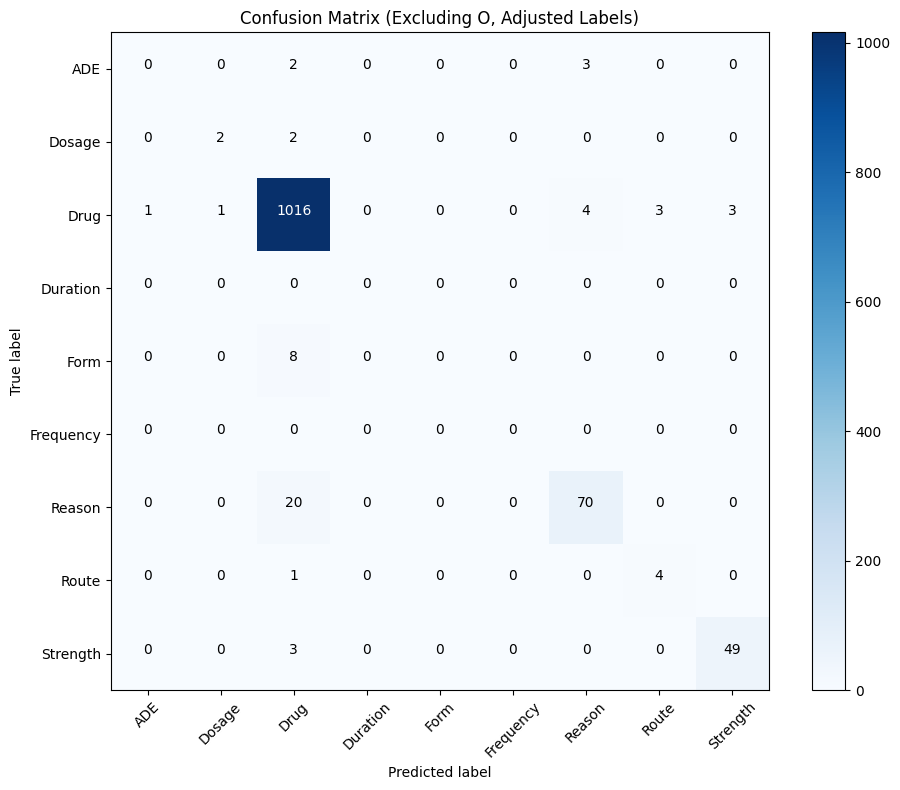

In [ ]:
results = trainer.evaluate()

print(f"Validation Accuracy: {results['eval_accuracy']}")
print(f"Validation Micro F1: {results['eval_micro_f1']}")
print(f"Validation Macro F1: {results['eval_macro_f1']}")
print(f"Validation Precision: {results['eval_precision']}")
print(f"Validation Recall: {results['eval_recall']}")

conf_matrix = results['eval_conf_matrix']
labels_unique = results['eval_labels_unique']
plot_confusion_matrix_load(conf_matrix, [model.config.id2label[l] for l in labels_unique])

In [ ]:
model.save_pretrained('./results')
tokenizer.save_pretrained('./results')

tokenizer = AutoTokenizer.from_pretrained('./results')
model = AutoModelForTokenClassification.from_pretrained('./results')

model.eval()

def tokenize_input(text):
    return tokenizer(text.split(), return_tensors="pt", is_split_into_words=True)

text = "Medications on Admission: citracal 600'', mycelox 5x/d, cod liver oil"

inputs = tokenize_input(text)

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

predictions = torch.argmax(logits, dim=2)

id2label = model.config.id2label

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
predicted_labels = [id2label[p.item()] for p in predictions[0]]

token_predictions = list(zip(tokens, predicted_labels))

for token, label in token_predictions:
    print(f"{token}: {label}")

[CLS]: O
Me: O
##dication: O
##s: O
on: O
Ad: O
##mission: O
:: O
c: B-Drug
##it: B-Drug
##rac: B-Drug
##al: B-Drug
600: B-Strength
': O
': O
,: O
my: B-Drug
##cel: B-Drug
##ox: B-Drug
5: B-Frequency
##x: B-Frequency
/: I-Frequency
d: I-Frequency
,: O
co: B-Drug
##d: B-Drug
liver: I-Drug
oil: I-Drug
[SEP]: O
